In [1]:
import numpy as np
import pulp as plp
import random
import matplotlib.pyplot as plt
import time
import networkx as nx

# GRAPH

In [2]:
def Create_Triangular_Graph(n):
    p=[]
    for j in range(1,n+1):
        for i in range(1,n+1):
            p.append((j%2 + 2*i - 3, 2*j-2))
    
    points = p
    N = len(points)
    points = sorted(points,key=lambda l:l[1])
    
    ############################################################################
    G = nx.Graph()
    
    
    G.add_nodes_from(points)
    
    dic={}  
    for n,(x,y) in zip(G.nodes(),points):
        dic[n] = (x,y)
    #############################################################################
    for a,b in G.nodes():
        if (a+1,b+2) in G.nodes():
            G.add_edge((a,b),(a+1,b+2))
        if (a-1,b+2) in G.nodes():
            G.add_edge((a,b),(a-1,b+2))
        if (a+2,b) in G.nodes():
            G.add_edge((a,b),(a+2,b))
    #####################################################################################
    return G,dic

In [3]:
def Add_Weights(H,k):
    
    N = len(H.edges())

    m=int(round(k*N))
    n=int(round((1-k)*N))

    a = np.ones(n+m)
    a[:m] = -1
    np.random.shuffle(a)
    
    dic={}
    for e,value in zip(H.edges(),a):
        dic[e] = value
    
    nx.set_edge_attributes(H, dic,'weight')
    
    return H

In [9]:
def color_nodes(G,variables):
    
    d = {}
    for key, value in variables.items():
        if "x" in key:
            #print(key[1:],value)
            d[int(key[1:])]=value

    var = dict(sorted(d.items()))
    
    node_colors=[]
    for key,value in var.items():
        if value==1:
            node_colors.append("black")
        else:
            node_colors.append("silver")
            
    attr = {}
    for (node,value),color in zip(G.nodes.data(),node_colors):
        #print(node,color)
        attr[node]=color
        
    nx.set_node_attributes(G, attr, 'color')
    
    return G

In [10]:
g,pos = Create_Triangular_Graph(10)

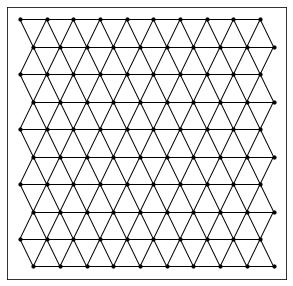

In [25]:
fig, ax = plt.subplots(figsize=(5,5))
nx.draw_networkx(g,pos=pos,node_size=10,with_labels=False,node_color="black")

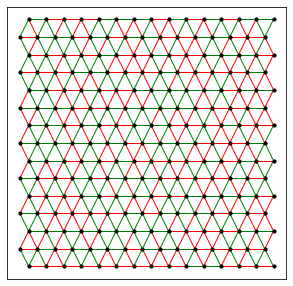

In [58]:
g2,pos = Create_Triangular_Graph(15)
g2 = Add_Weights(g2,0.5)

edge_colors = []
    
for key, value in nx.get_edge_attributes(g2,'weight').items():   
    if (value)==1.0:
        edge_colors.append("green")
    else:
        edge_colors.append("red")
        
fig, ax = plt.subplots(figsize=(5,5))
nx.draw_networkx(g2,pos=pos,node_size=10,with_labels=False,node_color="black", edge_color=edge_colors)

# Adjusting data

In [11]:
def Create_Data(matrices):

    signed_matrices=[]
    unsigned_matrices=[]
    weights = []
    graphs=[]
    for signed_matrix in matrices:

        Graph=nx.from_numpy_matrix(signed_matrix)

        mapping=dict(zip(Graph.nodes(),range(len(Graph.nodes()))))
        Graph=nx.relabel_nodes(Graph,mapping) 

        graphs.append(Graph)

        signed_matrix = nx.to_numpy_matrix(Graph)
        unsigned_matrix = abs(signed_matrix)    

        weighted_edges=nx.get_edge_attributes(Graph, 'weight') 
        w={}
        for (u,v) in weighted_edges:
            if u<v:
                w[(u,v)] = weighted_edges[(u,v)]
            if u>v:
                w[(v,u)] = weighted_edges[(u,v)]

        signed_matrices.append(signed_matrix)
        unsigned_matrices.append(unsigned_matrix)
        weights.append(w)

    return graphs, weights, signed_matrices

# GUROBI MODEL

In [12]:
from gurobipy import *
import multiprocessing

def Model(weights, signed_matrix):

    objectivevalue=[]
    objs=[]
    solveTime=[]
    
    index=0 
    order=len(signed_matrix[index])

    ###############################################################################################
    opt_model = plp.LpProblem(name="Binary_Model",sense = plp.LpMinimize)

    x=[]
    for i in range(0,order):
        x.append(plp.LpVariable(lowBound=0,upBound=1, cat=plp.LpBinary, name='x'+str(i)))
    z={}    
    for (i,j) in (weights[index]):
        z[(i,j)]=plp.LpVariable(lowBound=0,upBound=1, cat=plp.LpBinary, name='z'+str(i)+','+str(j))
    ###############################################################################################
    OFV = 0
    for (i,j) in (weights[index]):
        OFV += z[(i,j)]

    opt_model.setObjective(OFV)

    for (i,j) in (weights[index]):
        opt_model.addConstraint( z[(i,j)] >= x[i] - ((weights[index])[(i,j)])*x[j] -\
                        (1-(weights[index])[(i,j)])/2)
        opt_model.addConstraint( z[(i,j)] >= -x[i] + ((weights[index])[(i,j)])*x[j] +\
                        (1-(weights[index])[(i,j)])/2)   

    ###############################################################################################
    opt_model.solve(plp.GUROBI_CMD(options=[("MIPgap", 0.01),
                                            (GRB.Param.Threads, multiprocessing.cpu_count()),
                                           ('TimeLimit', 10*3600),
                                           (GRB.param.OutputFlag, 1)]))
    ###############################################################################################

    varsdict = {}
    for v in opt_model.variables():
        varsdict[v.name] = v.varValue
               
                    
    return float(opt_model.objective.value()), varsdict

In [16]:
def frustration_count(G):
    s = 0
    for n1,n2,val in G.edges.data():
        if G.nodes[n1]['color']==G.nodes[n2]['color'] and val['weight']==-1:
            s+=1
    return s

In [84]:
G,points = Create_Triangular_Graph(10)
G = Add_Weights(G,1.0)

edge_colors=[]
for key, value in nx.get_edge_attributes(G,'weight').items():   
    if (value)==1.0:
        edge_colors.append("green")
    else:
        edge_colors.append("red")

signed_matrix0 = nx.to_numpy_matrix(G)
graphs, weights, signed_matrices = Create_Data([signed_matrix0])
frustration_index,variables = Model(weights, signed_matrices)

print(frustration_index)

G = color_nodes(G,variables)

node_colors=[]
for key, value in nx.get_node_attributes(G,'color').items():   
    node_colors.append(value)

81.0


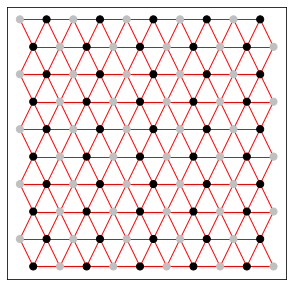

In [85]:
fig, ax = plt.subplots(figsize=(5,5))
nx.draw_networkx(G,pos=points,node_size=50,with_labels=False,node_color=node_colors, edge_color=edge_colors)

# Quench Calculation

In [17]:
from tqdm.notebook import tqdm

def Quench(n):
    
    
    graphs=[]
    frustrations = []
    #for i in range(500):
    for i in tqdm(range(500)):
        G,points = Create_Triangular_Graph(n)

        G = Add_Weights(G,1.0)
        matrix = nx.to_numpy_matrix(G)
        g, weights, signed_matrix = Create_Data([matrix])
        fi,vr = Model(weights, signed_matrix)
    
        frustrations.append(fi)
        G = color_nodes(G,vr)
        graphs.append((G,points,vr))

    p=0.0
    total=[]
    frustrations=[]
    start = time.time()
    ####################################################################################
    for g,j,k in tqdm(graphs):
        
        res=[]
        for i in range(0,1000):
        #for i in tqdm(range(1000)):

            H = nx.algorithms.double_edge_swap(g, nswap=1)
            H = Add_Weights(H,1.0)
            H = color_nodes(H,k)

            res.append(frustration_count(H))
        total.append(res)
    ####################################################################################        
    end = time.time()
    print("completed",end - start)
    
    total = np.array(total)
    final = []
    for i in range(0,len(total[0])):
        final.append((np.mean(total[:,i]),np.std(total[:,i])))
        
        
    return final,total

In [18]:
results, total = Quench(3)


completed 86.78428483009338


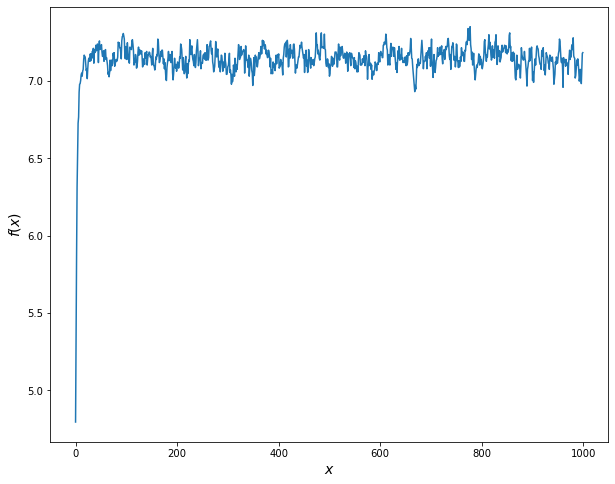

In [19]:
fig, ax = plt.subplots(figsize=[10,8])
ax.errorbar([x for x in range(len(results))],[y for y,z in results])#,[z for y,z in i])
ax.set_xlabel('$x$', fontsize=14)
ax.set_ylabel('$f(x)$', fontsize=14)
plt.show()